(introduction:analysis-frameworks)=

# Fundamental data structures and frameworks

## Single-cell analysis frameworks and consortia

After obtaining the count matrices, as described earlier, the exploratory data analysis phase begins.
Due to the size and complexity of the data, specialized tooling is required.
While in the early days of single-cell analysis, people used to analyze their data with custom scripts, frameworks for precisely this purpose now exist.
The three most popular options are the R-based Bioconductor {cite}`at:Huber2015` and Seurat {cite}`at:Hao2021` ecosystems and the Python-based scverse {cite}`scverse2022` ecosystem.
These differ not only in the used programming languages but also in the underlying data structures and available specialized analysis tools.

Bioconductor is a project that develops, supports, and shares free open-source software focusing on rigorous and reproducible data analysis for many different biological assays, including single-cell.
A homogeneous developer and user experience, as well as extensive documentation with user-friendly vignettes, are the biggest strengths of Bioconductor.
Seurat is a well-regarded R package specifically designed to analyze single-cell data.
It offers tooling for all analysis steps, including multimodal and spatial data.
Next to that, the well-written vignettes and the large user base are what Seurat is known for.
However, both R options can run into scalability issues for extremely large datasets (more than half a million cells), which motivated the Python-based community to develop the scverse ecosystem.
Scverse is an organization and an ecosystem dedicated to foundational tools in the life sciences with an initial focus on single-cell.
Scalability, extendability, and strong interoperability with the existing Python data and machine learning tooling are some advantages of the scverse ecosystem.

All three ecosystems are involved in many efforts to allow for interoperability of the involved frameworks.
This will be discussed in the "Interoperability" chapter.
This book always focuses on the best tools for the corresponding question and will, therefore, use a mix of the above-mentioned ecosystems for specific issues.
However, the basis of all analyses will be the scverse ecosystem for two reasons:

1. While we will regularly switch ecosystems and even programming languages throughout this book, consistent use of data structures and tooling helps readers focus on the concepts rather than implementation details.
2. [A great book on exclusively the Bioconductor ecosystem](https://bioconductor.org/books/release/OSCA/) already exists.
We encourage users who only want to learn about single-cell analysis with Bioconductor to read it.

In the following sections, the scverse ecosystem will be introduced in more detail, and the key concepts will be explained with a focus on the most important data structures.
This chapter introduces the fundamental data structure AnnData and the Scanpy framework (See {numref}`scverse-overview-fundamental`).
In the [following chapter](/jupyter-book/introduction/advanced_data_structures_and_frameworks.ipynb), we will explore more advanced libraries.
This introduction cannot cover all aspects of the data structures and frameworks.
It is not in scope to introduce all available analysis functions.
We, therefore, refer to the respective frameworks' tutorials and documentation where required.

:::{figure-md} scverse-overview-fundamental
<img src="../_static/images/analysis_tools/working_sheet/working_sheet.001.png" alt="Scverse ecosystem overview" class="bg-primary mb-1" width="100%">

Scverse ecosystem overview highlighting the libraries of this chapter. The publication date by a scientific journal is shown in brackets. We have obtained the symbols of the libraries from the corresponding Github pages {cite}`Virshup2021,Wolf2018,Bredikhin2022,Palla2022,Marconato2025`.
:::

## Storing unimodal data with AnnData

As previously discussed, genomics data is typically summarized into a feature matrix after alignment and gene {term}`annotation`.
This matrix will be of the shape `number_observations x number_variables`.
In scRNA-seq, observations are cellular barcodes, and the variables are annotated genes.
Throughout the analysis, the observations and variables of this matrix are annotated with computationally derived measurements (e.g., quality control metrics or latent space embeddings) and prior knowledge (e.g., source donor or alternative gene identifier).
In the scverse ecosystem, {term}`AnnData` {cite}`Virshup2021` is used to associate the data matrix with these annotations.
To allow for fast and memory-efficient transformations, AnnData also supports {term}`sparse matrices <sparse matrix>` and partial reading.

While AnnData is broadly similar to data structures from the R ecosystems (e.g., [Bioconductor's SummarizedExperiment](https://bioconductor.org/packages/release/bioc/html/SummarizedExperiment.html) or [Seurat's object](https://rdrr.io/github/mojaveazure/seurat-object/)), R packages use a transposed feature matrix.

At its core, an AnnData object stores a sparse or dense matrix (the count matrix in the case of scRNA-Seq) in `X`.
This matrix has the dimensions of `obs_names x var_names` where the obs (=observations) correspond to the cells' barcodes and the var (=variables) correspond to the gene identifiers.
This matrix `X` is surrounded by Pandas DataFrames `obs` and `var`, which save annotations of cells and genes, respectively.
Further, AnnData saves whole matrices of calculations for the observations (`obsm`) or variables (`varm`) with the corresponding dimensions.
Graph-like structures that associate cells with cells or genes with genes are usually saved in `obsp` and `varp`.
Any other unstructured data which does not fit any other slot is saved as unstructured data in `uns`.
It is further possible to store more values of `X` in `layers`.
Use cases for this are, for example, the storage of raw, unnormalized count data in a `counts` layer and the normalized data in the unnamed default layer.
AnnData is primarily designed for unimodal (for example, just scRNA-Seq) data.
However, extensions of AnnData, such as {term}`MuData`, which is covered later in this chapter, allow for the efficient storage and access of multimodal data.

:::{figure-md} anndata-fig
<img src="../_static/images/analysis_tools/anndata.jpg" alt="AnnData Overview" class="bg-primary mb-1" width="800px">

AnnData overview. Image obtained from {cite}`Virshup2021`.
:::

### Installation

AnnData is available on PyPI, and Conda can be installed by using either:
```bash
pip install anndata
conda install -c conda-forge anndata
```

### Initializing an AnnData object

This section is inspired by [AnnData's "getting started" tutorial](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html). Let us create a simple AnnData object with {term}`sparse <sparse data>` count information, which may, for example, represent gene expression counts. First, we import the required packages.

import warnings
warnings.filterwarnings("ignore")

In [57]:
import anndata as ad
import numpy as np
import pandas as pd
import lamindb as ln
from scipy.sparse import csr_matrix

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"
ln.track()

→ loaded Transform('zmuES9DakbmX0000', key='fundamental_data_structures_and_frameworks.ipynb'), re-started Run('pVMXOM3UaklSn6tp') at 2026-01-15 13:21:21 UTC
→ notebook imports: anndata==0.12.7 lamindb==2.0.1 numpy==2.3.5 pandas==2.3.3 scanpy==1.11.5 scipy==1.16.3
• recommendation: to identify the notebook across renames, pass the uid: ln.track("zmuES9DakbmX")


As a next step, we initialize an AnnData object with random {term}`Poisson distributed <Poisson distribution>` data. It is an unwritten rule to name the primary AnnData object of the analysis `adata`.

In [58]:
counts = csr_matrix(
    np.random.default_rng().poisson(1, size=(100, 2000)), dtype=np.float32
)
adata = ad.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 100 × 2000

The obtained AnnData object has 100 observations and 2000 variables. This would correspond to 100 cells with 2000 genes. The initial data we passed are accessible as a sparse matrix using `adata.X`.

In [59]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 126443 stored elements and shape (100, 2000)>

Now, we provide the index to both the `obs` and `var` axes using `.obs_names` and `.var_names`, respectively.

In [60]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


### Adding aligned metadata

#### Observational or Variable level

The core of our AnnData object is now in place.
As a next step, we add metadata at both the observational and variable levels.
Remember, we store such annotations in the `.obs` and `.var` slots of the AnnData object for cell and gene annotations, respectively.

In [61]:
ct = np.random.default_rng().choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs["cell_type"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
adata.obs

,cell_type
Cell_0,Monocyte
Cell_1,B
Cell_2,Monocyte
Cell_3,B
Cell_4,Monocyte
...,...
Cell_95,T
Cell_96,B
Cell_97,Monocyte
Cell_98,B


If we examine the representation of the AnnData object again now, we will notice that it was updated with the `cell_type` information in `obs` as well.

In [62]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'

#### Subsetting using metadata

We can also subset the AnnData object with the randomly generated cell types.
The slicing and masking of the AnnData object behaves similarly to the data access in Pandas DataFrames or R matrices.
More details on this can be found [below](#subset-adata).

In [63]:
bdata = adata[adata.obs.cell_type == "B"]
bdata

View of AnnData object with n_obs × n_vars = 38 × 2000
    obs: 'cell_type'

### Observation/variable-level matrices

We might also have metadata at either level with many dimensions, such as a UMAP embedding of the data.
AnnData has the `.obsm/.varm` attributes for this type of metadata.
We use keys to identify the different matrices we insert.
The restriction of `.obsm/.varm` is that `.obsm` matrices must have a length equal to the number of observations as `.n_obs` and `.varm` matrices must have a length equal to `.n_vars`.
They can each independently have a different number of dimensions.

Let us start with a randomly generated matrix that we can interpret as a UMAP embedding of the data we would like to store, as well as some random gene-level metadata.

In [64]:
adata.obsm["X_umap"] = np.random.default_rng().normal(0, 1, size=(adata.n_obs, 2))
adata.varm["gene_stuff"] = np.random.default_rng().normal(0, 1, size=(adata.n_vars, 5))
adata.obsm

AxisArrays with keys: X_umap

Again, the AnnData representation is updated.

In [65]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    obsm: 'X_umap'
    varm: 'gene_stuff'

A few more notes about `.obsm/.varm`:

1. The “array-like” metadata can originate from a Pandas DataFrame, scipy sparse matrix, or numpy dense array.
2. When using scanpy, their values (columns) are not easily plotted, whereas items from `.obs` are easily plotted on, e.g., UMAP plots.


### Unstructured metadata

As mentioned above, AnnData has `.uns`, which allows for any unstructured metadata.
This can be anything, like a list or a dictionary, with some general information that was useful in the analysis of our data.
Try only using this slot for data that cannot be efficiently stored in the other slots.


In [66]:
adata.uns["random"] = [1, 2, 3]
adata.uns

OrderedDict([('random', [1, 2, 3])])

### Layers

Finally, we may have different forms of our original core data, perhaps one that is normalized and one that is not.
These can be stored in different layers in AnnData.
For example, let us log transform the original data and store it in a layer.

In [67]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

Our original matrix `X` was not modified and is still accessible.
We can verify this by comparing the original `X` to the new layer (`.nnz` returns number of non-zero elements in the boolean matrix).

In [68]:
(adata.X != adata.layers["log_transformed"]).nnz == 0

False

### Conversion to DataFrames

It is possible to obtain a Pandas DataFrame from one of the layers.

In [69]:
adata.to_df(layer="log_transformed")

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18,Gene_19,Gene_20,Gene_21,Gene_22,Gene_23,Gene_24,Gene_25,Gene_26,Gene_27,Gene_28,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38,Gene_39,Gene_40,Gene_41,Gene_42,Gene_43,Gene_44,Gene_45,Gene_46,Gene_47,Gene_48,Gene_49,Gene_50,Gene_51,Gene_52,Gene_53,Gene_54,Gene_55,Gene_56,Gene_57,Gene_58,Gene_59,Gene_60,Gene_61,Gene_62,Gene_63,Gene_64,Gene_65,Gene_66,Gene_67,Gene_68,Gene_69,Gene_70,Gene_71,Gene_72,Gene_73,Gene_74,Gene_75,Gene_76,Gene_77,Gene_78,Gene_79,Gene_80,Gene_81,Gene_82,Gene_83,Gene_84,Gene_85,Gene_86,Gene_87,Gene_88,Gene_89,Gene_90,Gene_91,Gene_92,Gene_93,Gene_94,Gene_95,Gene_96,Gene_97,Gene_98,Gene_99,...,Gene_1900,Gene_1901,Gene_1902,Gene_1903,Gene_1904,Gene_1905,Gene_1906,Gene_1907,Gene_1908,Gene_1909,Gene_1910,Gene_1911,Gene_1912,Gene_1913,Gene_1914,Gene_1915,Gene_1916,Gene_1917,Gene_1918,Gene_1919,Gene_1920,Gene_1921,Gene_1922,Gene_1923,Gene_1924,Gene_1925,Gene_1926,Gene_1927,Gene_1928,Gene_1929,Gene_1930,Gene_1931,Gene_1932,Gene_1933,Gene_1934,Gene_1935,Gene_1936,Gene_1937,Gene_1938,Gene_1939,Gene_1940,Gene_1941,Gene_1942,Gene_1943,Gene_1944,Gene_1945,Gene_1946,Gene_1947,Gene_1948,Gene_1949,Gene_1950,Gene_1951,Gene_1952,Gene_1953,Gene_1954,Gene_1955,Gene_1956,Gene_1957,Gene_1958,Gene_1959,Gene_1960,Gene_1961,Gene_1962,Gene_1963,Gene_1964,Gene_1965,Gene_1966,Gene_1967,Gene_1968,Gene_1969,Gene_1970,Gene_1971,Gene_1972,Gene_1973,Gene_1974,Gene_1975,Gene_1976,Gene_1977,Gene_1978,Gene_1979,Gene_1980,Gene_1981,Gene_1982,Gene_1983,Gene_1984,Gene_1985,Gene_1986,Gene_1987,Gene_1988,Gene_1989,Gene_1990,Gene_1991,Gene_1992,Gene_1993,Gene_1994,Gene_1995,Gene_1996,Gene_1997,Gene_1998,Gene_1999
Cell_0,0.000000,1.098612,1.386294,0.000000,0.000000,0.693147,1.098612,0.693147,1.098612,0.693147,0.000000,0.693147,1.098612,0.693147,0.000000,0.000000,1.098612,0.693147,0.693147,0.000000,1.098612,1.098612,0.693147,0.000000,0.693147,1.609438,0.000000,0.000000,1.098612,0.000000,0.693147,0.693147,0.693147,1.098612,0.693147,0.693147,0.000000,0.693147,1.098612,0.693147,0.693147,0.000000,0.000000,0.000000,0.693147,1.609438,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.693147,1.098612,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,1.609438,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.693147,0.000000,1.609438,1.609438,0.000000,0.693147,0.000000,0.693147,1.386294,1.098612,1.098612,0.000000,1.386294,0.000000,1.386294,0.000000,1.098612,0.693147,1.098612,0.693147,0.693147,1.609438,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,1.098612,0.000000,0.693147,1.098612,...,0.000000,1.098612,1.098612,0.693147,1.098612,0.693147,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,1.386294,0.000000,1.098612,0.000000,0.000000,0.693147,0.000000,0.693147,1.098612,1.386294,1.098612,0.693147,0.693147,0.000000,1.386294,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.000000,1.098612,1.098612,0.693147,0.693147,1.386294,0.693147,0.000000,0.693147,1.098612,1.098612,0.693147,0.693147,1.098612,0.693147,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,1.098612,0.693147,0.000000,0.000000,1.609438,0.000000,0.693147,0.000000,1.386294,1.386294,1.098612,1.386294,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000,0.693147,1.098612,0.000000,0.693147,1.098612,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,1.098612,1.098612,1.609438
Cell_1,0.693147,1.098612,0.000000,1.386294,1.098612,0.693147,0.000000,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.693147,1.098612,0.000000,0.000000,1.098612,0.000000,0.693147,0.693147,1.609438,0.693147,0.693147,0.000000,1.098612,1.098612,0.000000,0.000000,0.693147,0.693147,0.000000,1.098612,0.000000,0.000000,

### Reading and writing of AnnData objects

AnnData objects can be saved on disk to hierarchical array stores like [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) or [Zarr](https://zarr.readthedocs.io/en/stable/index.html) to enable similar structures in disk and on memory.
AnnData comes with its own persistent HDF5-based file format: `h5ad`.
If string columns with a few categories are not yet categorical, AnnData will auto-transform them to categorical. We will now save our AnnData object in `h5ad` format.

In [70]:
adata.write("my_results.h5ad", compression="gzip")

... and read it back in.

In [71]:
adata_new = ad.read_h5ad("my_results.h5ad")
adata_new

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

### Efficient data access

#### View and copies

For the fun of it, let us look at another metadata use case.
Imagine that the observations come from instruments characterizing 10 readouts in a multi-year study with samples taken from different subjects at different sites.
We would typically get that information in some format and then store it in a DataFrame:

In [72]:
obs_meta = pd.DataFrame(
    {
        "time_yr": np.random.default_rng().choice([0, 2, 4, 8], adata.n_obs),
        "subject_id": np.random.default_rng().choice(
            ["subject 1", "subject 2", "subject 4", "subject 8"], adata.n_obs
        ),
        "instrument_type": np.random.default_rng().choice(
            ["type a", "type b"], adata.n_obs
        ),
        "site": np.random.default_rng().choice(["site x", "site y"], adata.n_obs),
    },
    index=adata.obs.index,  # these are the same IDs of observations as above!
)

This is how we join the readout data with the metadata.
Of course, the first argument of the following call for `X` could also just be a DataFrame.
This will result in a single data container that tracks everything.

In [73]:
adata = ad.AnnData(adata.X, obs=obs_meta, var=adata.var)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

<a id="subset-adata"></a>
Subsetting the joint data matrix can be important to focus on subsets of variables or observations, or to define train-test splits for a machine learning model.

Similar to numpy arrays, AnnData objects can either hold actual data or reference another `AnnData` object.
In the latter case, they are referred to as "view".
Subsetting AnnData objects always returns views, which has two advantages:

- No new memory is allocated.
- It is possible to modify the underlying AnnData object.
 
You can get an actual AnnData object from a view by calling `.copy()` on the view.
Usually, this is not necessary, as any modification of elements of a view (calling `.[]` on an attribute of the view) internally calls `.copy()` and makes the view an AnnData object that holds actual data.
See the example below.

In [74]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

Indexing into AnnData will assume that integer arguments to `[]` behave like `.iloc` in pandas, whereas string arguments behave like `.loc`.
`AnnData` always assumes string indices.

In [75]:
adata_view = adata[:5, ["Gene_1", "Gene_3"]]
adata_view

View of AnnData object with n_obs × n_vars = 5 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

This is a view! This can be verified by examining the AnnData object again.

In [76]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

The dimensions of the AnnData object have not changed. It still contains the same data.
If we want an AnnData that holds the data in memory, we must call it `.copy()`.

In [77]:
adata_subset = adata[:5, ["Gene_1", "Gene_3"]].copy()
adata_subset

AnnData object with n_obs × n_vars = 5 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

For a view, we can also set the first three elements of a column.

In [78]:
print(adata[:3, "Gene_1"].X.toarray().tolist())
adata[:3, "Gene_1"].X = [0, 0, 0]
print(adata[:3, "Gene_1"].X.toarray().tolist())

[[2.0], [2.0], [2.0]]
[[0.0], [0.0], [0.0]]


/var/folders/dy/0ztxj7hd3h3cz5ghg9zsd3bh0000gn/T/ipykernel_12691/109358169.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata[:3, "Gene_1"].X = [0, 0, 0]


If you try to access parts of a view of an AnnData, the content will be auto-copied and a data-storing object will be generated.

In [79]:
adata_subset = adata[:3, ["Gene_1", "Gene_2"]]
adata_subset

View of AnnData object with n_obs × n_vars = 3 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

In [80]:
adata_subset.obs["foo"] = range(3)

/var/folders/dy/0ztxj7hd3h3cz5ghg9zsd3bh0000gn/T/ipykernel_12691/1197528106.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs["foo"] = range(3)


Now `adata_subset` stores the actual data and is no longer just a reference to adata.

In [81]:
adata_subset

AnnData object with n_obs × n_vars = 3 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site', 'foo'

Evidently, you can use all of pandas to slice with sequences or boolean indices.

In [82]:
adata[adata.obs.time_yr.isin([2, 4])].obs.head()

,time_yr,subject_id,instrument_type,site
Cell_0,2,subject 4,type b,site x
Cell_2,2,subject 8,type b,site x
Cell_4,2,subject 2,type b,site x
Cell_6,4,subject 8,type b,site y
Cell_8,4,subject 1,type a,site y


#### Partial reading of large data

If a single `h5ad` file is very large, you can partially read it into memory by using backed mode.

In [83]:
adata = ad.read_h5ad("my_results.h5ad", backed="r")

In [84]:
adata.isbacked

True

If you do this, you will need to remember that the AnnData object has an open connection to the file used for reading.

In [85]:
adata.filename

PosixPath('my_results.h5ad')

As we are using it in read-only mode, we cannot damage anything. To proceed with this tutorial, we still need to explicitly close it.

In [86]:
adata.file.close()

## Unimodal data analysis with scanpy

Now that we understand the fundamental data structure of unimodal single-cell analysis, the question remains: How can we actually analyze the stored data?
In the scverse ecosystem, several tools exist for analyzing specific omics data.
For example, scanpy {cite}`Wolf2018` provides tooling for general RNA-Seq-focused analysis, squidpy {cite}`Palla2022` focuses on spatial transcriptomics, and scirpy {cite}`Sturm2020` provides tooling for the analysis of T-cell receptor (TCR) and B-cell receptor (BCR) data.
Even though many scverse extensions for various data modalities exist, they usually use some of scanpy's preprocessing and visualization capabilities to some extent.

More specifically, scanpy is a Python package that builds on top of AnnData to facilitate the analysis of single-cell gene expression data.
Several methods for preprocessing, embedding, visualization, clustering, differential gene expression testing, pseudotime and trajectory inference, and simulation of gene regulatory networks are accessible through scanpy.
The efficient implementation based on the Python data science and machine learning libraries allows scanpy to scale to millions of cells.
Generally, best-practice single-cell data analysis is an interactive process.
Many of the decisions and analysis steps depend on the results of previous steps and the potential input of experimental partners.
Pipelines such as scflow {cite}`at:Khozoie2021` entirely automate some downstream analysis steps.
These pipelines have to make assumptions and simplifications, which may not result in the most robust analysis.
Scanpy is therefore designed for interactive analyses with, for example, Jupyter Notebooks {cite}`jupyter`.

:::{figure-md} scanpy-fig
<img src="../_static/images/analysis_tools/scanpy.jpg" alt="scanpy Overview" class="bg-primary mb-1" width="800px">

scanpy overview. Image obtained from {cite}`Wolf2018`.
:::

### Installation

scanpy is available on PyPI and Conda can be installed with using either:
```bash
pip install scanpy
conda install -c conda-forge scanpy
```

### Scanpy API design

The scanpy framework is designed in a way that functions belonging to the same step are grouped into corresponding modules.
For example, all preprocessing functions are available in the `scanpy.preprocessing` module, all transformations of a data matrix that are not preprocessing are available in `scanpy.tools`, and all visualizations are available in `scanpy.plot`.
These modules are commonly accessed after having imported scanpy like `import scanpy as sc` with the corresponding abbreviations `sc.pp` for preprocessing, `sc.tl` for tools, and `sc.pl` for plots.
All modules which read or write data are directly accessed.
Further, a module for various datasets is available as `sc.datasets`.
All functions with corresponding parameters and potential example plots are documented in the scanpy API documentation {cite}`scanpy_api`.

Note that this tutorial only covers a tiny subset of scanpy's features and options.
Readers are strongly encouraged to examine [scanpy's documentation](https://scanpy.readthedocs.io/) for more details.


:::{figure-md} scanpy-api
<img src="../_static/images/analysis_tools/scanpy_api.png" alt="scanpy API" class="bg-primary mb-1" width="800px">

scanpy API overview. The API is divided into datasets, preprocessing (pp), tools (tl) and corresponding plotting (pl) functions.
:::

### Scanpy example

In the following cells we will shortly demonstrate the workflow of an analysis with scanpy. We explicitly do not conduct a full analysis because the specific analysis steps are covered in the corresponding chapters.

As a first step we import scanpy and define defaults for our following quick scanpy demo. We use scanpy's setting object to  set the Matplotlib plotting defaults for all of scanpy's plots and finally print scanpy's header. This header contains the versions of all relevant Python packages in the current environment including Scanpy and AnnData. This output is especially useful when reporting bugs to the scverse team and for reproducibility reasons.

In [87]:
import scanpy as sc

sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

/var/folders/dy/0ztxj7hd3h3cz5ghg9zsd3bh0000gn/T/ipykernel_12691/1331650924.py:4: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


Package,Version
pandas,2.3.3
anndata,0.12.7
numpy,2.3.5
lamindb,2.0.1
scipy,1.16.3
scanpy,1.11.5
Component,Info
Python,"3.13.11 | packaged by conda-forge | (main, Dec 6 2025, 11:28:54) [Clang 19.1.7 ]"
OS,macOS-15.6.1-arm64-arm-64bit-Mach-O
CPU,"8 logical CPU cores, arm"


The dataset of choice is a dataset of 2700 peripheral blood mononuclear cells of a healthy donor which were sequenced on the Illumina NextSeq 500. We can load the dataset from `lamindb`, although it is also available via `sc.datasets.pbmc3k()`.

In [88]:
adata2 = sc.datasets.pbmc3k()

In [89]:
adata2

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [90]:
af = ln.Artifact.connect("theislab/sc-best-practices").get(
    key="introduction/fundamental_data_structures_and_frameworks.h5ad", is_latest=True
)
adata = af.load()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

The returned AnnData object has 2700 cells with 32738 genes. The `var` slot further contains the gene IDs.

In [91]:
adata.var

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180


As mentioned above, all of scanpy's analysis functions are accessible via `sc.[pp, tl, pl]`. As a first step to get an overview over our data, we use scanpy to show those genes that yield the highest fraction of counts in each single cell, across all cells. We simply call the `sc.pl.highest_expr_genes` function, pass the AnnData object which is in pretty much all cases the first parameter of any scanpy function, and specify that we want the top 20 expressed genes to be shown.

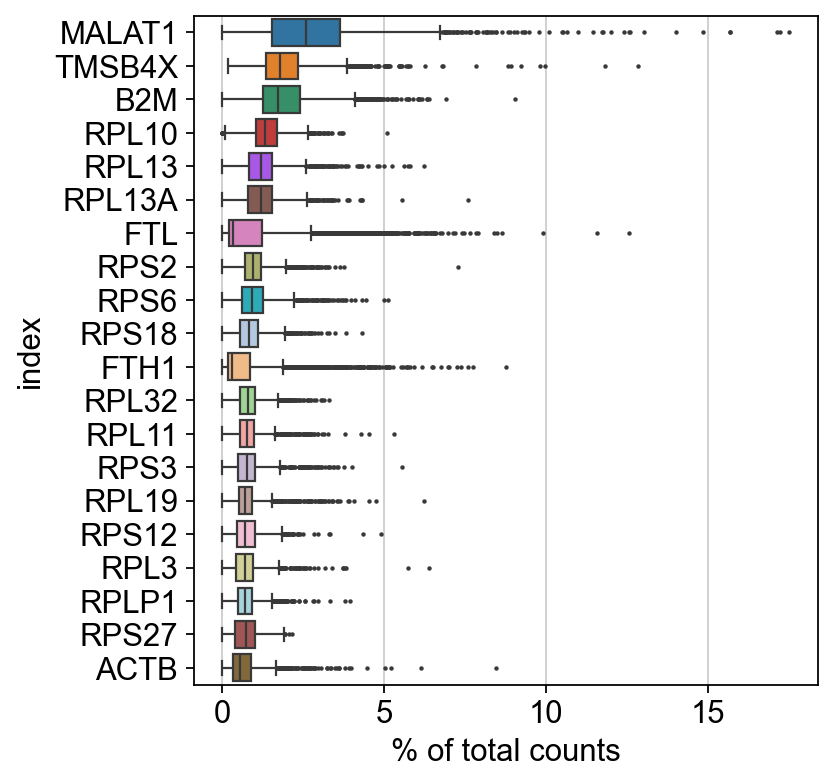

In [92]:
sc.pl.highest_expr_genes(adata, n_top=20)

Apparently, MALAT1 is the most expressed gene which is frequently detected in poly-A captured scRNA-Seq data, independent of protocol. This gene has been shown to have an inverse correlation with cell health. Especially dead/dying cells have a higher expression of MALAT1.

We now filter cells with less than 200 detected genes and genes which were found in less than 3 cells for a rough quality threshold with scanpy's preprocessing module.

In [93]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

A common step in single-cell RNA-Seq analysis is dimensionality reduction with for example principal component analysis (PCA) to unveil the main axes of variation. This also denoises the data. Scanpy offers PCA as a `preprocessing` or `tools` function. These are equivalent. Here, we use the version in `tools` for no particular reason. 

In [94]:
sc.tl.pca(adata, svd_solver="arpack")

The corresponding plotting function allows us to pass genes to the color argument. The corresponding values are automatically extracted from the AnnData object.

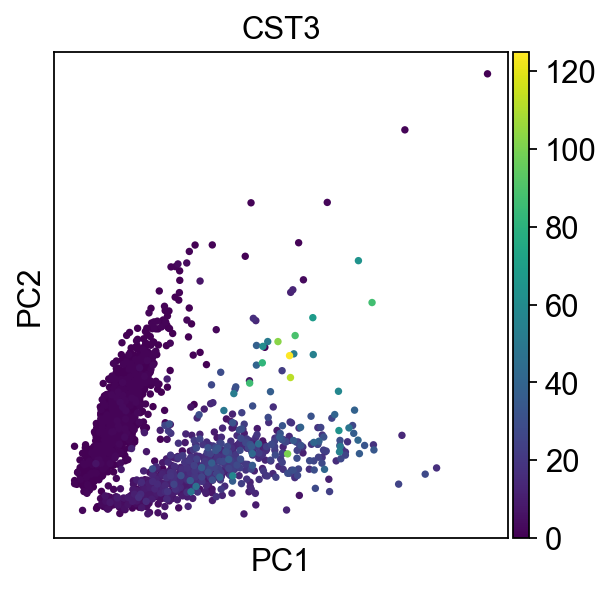

In [95]:
sc.pl.pca(adata, color="CST3")

A fundamental step for any advanced embedding and downstream calculations is the calculating of the neighborhood graph using the PCA representation of the data matrix. It is automatically used for other tools that require it such as the calculation of a UMAP.

In [96]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

We now use the calculating neighborhood graph to embed the cells with a UMAP, one of many advanced dimension reduction {term}`algorithms <algorithm>` implemented in scanpy.

In [97]:
sc.tl.umap(adata)

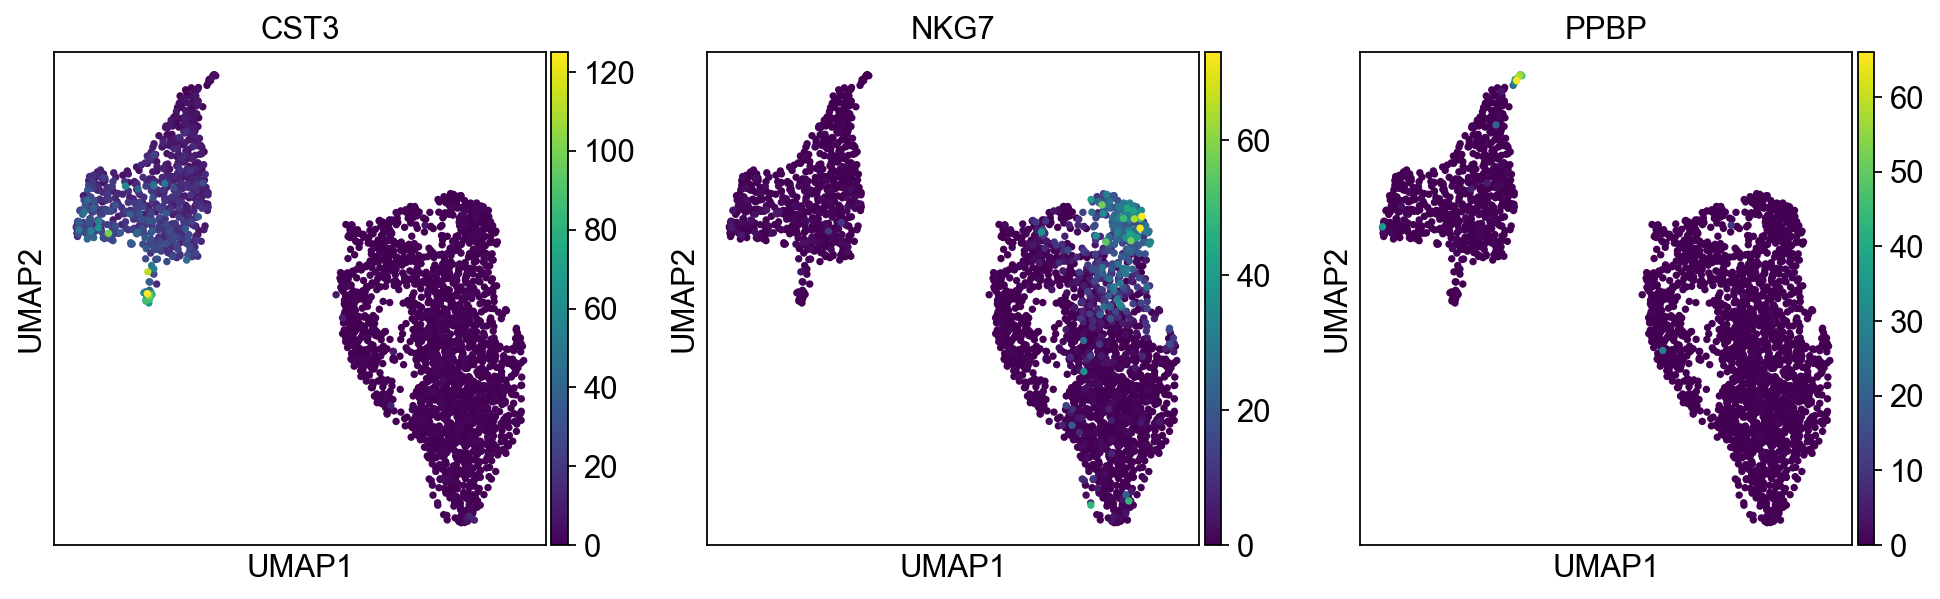

In [98]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

Scanpy's documentation also provides [tutorials](https://scanpy.readthedocs.io/en/stable/tutorials.html) which we recommend to all readers who need a refresher of scanpy or are new to scanpy. Video tutorials are available on the [scverse youtube channel](https://www.youtube.com/channel/UCpsvsIAW3R5OdftJKKuLNMA).

## Questions
### Flipcards

In [99]:
%run ../src/lib.py

flip_card(
    "q1",
    "What is the fundamental data structure for single-cell analysis in the scverse?",
    "AnnData",
)

flip_card(
    "q1",
    "What is the fundamental framework for single-cell analysis in the scverse?",
    "Scanpy",
)

flip_card(
    "q1",
    "In single-cell RNA-seq data, which dimensions correspond to genes and cells?",
    "Genes are stored in `var` (columns), and cells are stored in `obs` (rows) of the matrix.",
)

Exception: File `'../src/lib.py'` not found.

### Flipcards

In [ ]:
%run ../src/lib.py

mc_question(
    "q4",
    "What is a common limitation of the R-based frameworks Bioconductor and Seurat when analyzing very large single-cell datasets?",
    [
        "Inability to store gene annotations",
        "Lack of preprocessing functions",
        "Scalability issues with more than ~500,000 cells",
        "Lack of comprehensive documentation",
    ],
    correct="Scalability issues with more than ~500,000 cells"
)

mc_question(
    "q3",
    "In an AnnData object, which slot stores the main count matrix for scRNA-seq data?",
    [
        "X",
        "obs",
        "var",
        "uns"
    ],
    correct="X"
)

mc_question(
    "q3",
    "Where would you store additional matrices derived from the main data, such as normalized counts or log-transformed values, in an AnnData object?",
    [
        "layers",
        "obsm",
        "varp",
        "uns"
    ],
    correct="layers"
)

Exception: File `'../src/lib.py'` not found.

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: at
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos
* Luis Heinzmeier

### Reviewers

* Isaac Virshup